## Setup

In [1]:
#from load import load 
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import torch
from torch import nn
from torchsummary import summary
import mlflow
from typing import Callable, Dict, Optional, Type, Any, List
import math
import pyro.distributions.constraints as constraints
import pyro.distributions as dist

import os

from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition
from chirho.interventional.handlers import do
from chirho.observational.handlers.soft_conditioning import soft_eq, KernelSoftConditionReparam

from chirho.dynamical.handlers import (
    DynamicIntervention,
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.indexed.ops import IndexSet, gather, indices_of
# import importlib
# from chirho.explainable.handlers import explanation
# importlib.reload(explanation)
# from chirho.explainable.handlers.explanation import SearchForExplanation

# import pyro
# import pyro.distributions as dist
# from chirho.interventional.handlers import do

# from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel

import pyro

from pyro.infer import Predictive
from pyro.infer.autoguide import AutoGuide, AutoMultivariateNormal, init_to_mean

from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports
import matplotlib

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import seaborn as sns
from pypalettes import load_cmap


from torch.distributions.utils import broadcast_all
from collections import OrderedDict

smoke_test = "CI" in os.environ


num_samples = 100 if not smoke_test else 30
num_steps = 300 if not smoke_test else 10
epochs = 300 if not smoke_test else 10


device = "cuda" if torch.cuda.is_available() else "cpu"

#mlflow.set_tracking_uri("file:../../mlruns")


## Fishery model

/tmp/ipykernel_57117/246495209.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


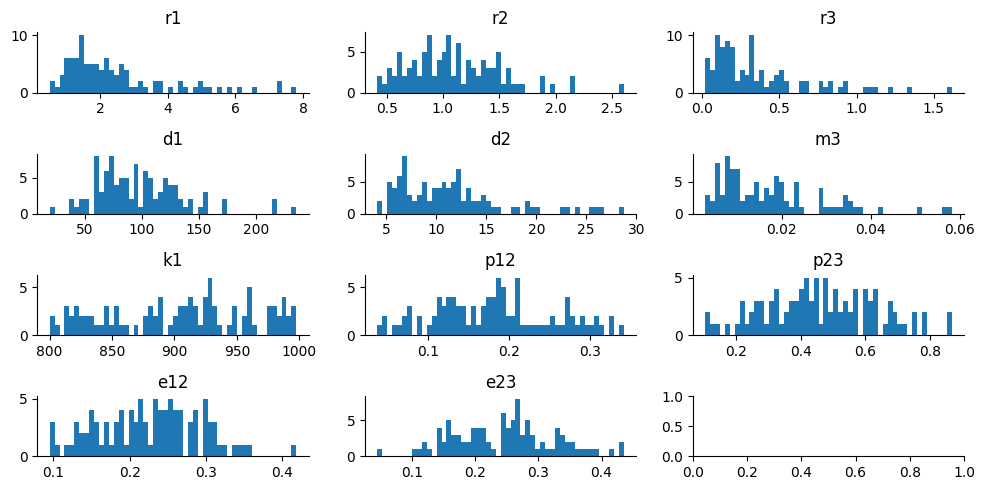

In [2]:
loc_scale_for_prior = OrderedDict(
    r1=dict(loc=0.76, scale=0.59),
    r2=dict(loc=0.0, scale=0.42),
    r3=dict(loc=-1.3, scale=0.79),
    d1=dict(loc=4.61, scale=0.42),
    d2=dict(loc=2.30, scale=0.42),
    m3=dict(loc=-4.232, scale=0.6)
)

def sample_fishery_priors():
    sampled =  {
        key: pyro.sample(key, dist.LogNormal(value["loc"], value["scale"]))
        for key, value in loc_scale_for_prior.items()
    }

    sampled['k1'] = pyro.sample('k1', dist.Uniform(800, 1000.))
    sampled['p12'] = pyro.sample('p12', dist.Beta(3., 6.))/2
    sampled['p23'] = pyro.sample('p23', dist.Beta(4., 5.))
    sampled['e12'] = pyro.sample('e12', dist.Beta(5., 6.))/2
    sampled['e23'] = pyro.sample('e23', dist.Beta(5., 6.))/2

    return sampled

with pyro.plate("prior", num_samples):
    param_samples = sample_fishery_priors()


fig, ax = plt.subplots(4, 3, figsize=(10, 5))
ax = ax.flatten()

i = 0 
for key, value in param_samples.items():
    ax[i].hist(value.detach().numpy(), bins=50)
    ax[i].set_title(key)
    i += 1
   
sns.despine()
fig.tight_layout()
fig.show()


In [3]:
param_sample_medians = {
    key: value.median()
    for key, value in param_samples.items()
}

INITIAL_STATE_no_pressure = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    'catch_intermediate': torch.tensor(0.0),
    'fishing_effort_forage': torch.tensor(0.0),
    'fishing_effort_intermediate': torch.tensor(0),
    'fishing_effort_apex': torch.tensor(0.0),
}



INITIAL_STATE_pressure = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    'catch_intermediate': torch.tensor(0.0),
    'fishing_effort_forage': torch.tensor(0.0),
    'fishing_effort_intermediate': torch.tensor(0.7),
    'fishing_effort_apex': torch.tensor(0.07),
}

def add_postfix_to_dict(d, postfix):
    return {f"{k}_{postfix}": v for k, v in d.items()}

INITIAL_STATE_NO_PRESSURE = add_postfix_to_dict(INITIAL_STATE_no_pressure, "no_pressure")
INITIAL_STATE_PRESSURE = add_postfix_to_dict(INITIAL_STATE_pressure, "pressure")
INITIAL_STATE_DEPENDENT = add_postfix_to_dict(INITIAL_STATE_pressure, "dependent")
INITIAL_STATE_STATIC = add_postfix_to_dict(INITIAL_STATE_pressure, "static")


In [4]:

class FishDynamics(pyro.nn.PyroModule):
    def __init__(self, params: Dict = param_sample_medians, postfix: str = ""):
        super().__init__()
        self.params = params
        self.postfix = postfix
    

    @staticmethod
    def holling_tanner(B: torch.Tensor, r: torch.Tensor, K: torch.Tensor, 
                    M: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        The general holling-tanner differential equation.
        This subtracts predator and fishing mortality from capacity-limited growth.
        B is the biomass for this trophic level.
        K is its carrying capacity, which may be a function of prey biomass.
        M is the mortality rate, potentially due to predation.
        F is the fishing mortality rate.
        """
        return r * B * (1 - B / K) - M * B - F * B

    @staticmethod
    def mortality_from_predation(B: torch.Tensor, B_pred: torch.Tensor, 
                                p: torch.Tensor, D: torch.Tensor) -> torch.Tensor:
        """
        Mortality rate of prey due to predation.
        This plugs in as M above for prey species with biomass B.
        p is the maximum rate of predation.
        B is the biomass of the prey, and B_pred is the biomass of the predator.
        D is the biomass when the predation rate reaches half of its maximum.
        """
        return (p * B_pred) / (D + B)

    @staticmethod
    def carrying_capacity_of_predator(B_prey: torch.Tensor, e: torch.Tensor) -> torch.Tensor:
        """
        Carrying capacity of the predator — this plugs in as K above for predator species.
        e is the proportion of prey biomass that is converted into predator biomass.
        """
        return B_prey * e

    @staticmethod
    def intermediate_trophic_level(B: torch.Tensor, r: torch.Tensor, B_prey: torch.Tensor, 
                                e: torch.Tensor, B_pred: torch.Tensor, p: torch.Tensor, 
                                D: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        Equation for intermediate trophic levels that are both prey and predator.
        """
        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)
        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def apex_trophic_level(B: torch.Tensor, r: torch.Tensor, B_prey: torch.Tensor, 
                        e: torch.Tensor, M: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        The top trophic level that has some constant natural mortality rate.
        """
        
        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)
       
        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def forage_trophic_level(B: torch.Tensor, r: torch.Tensor, K: torch.Tensor, 
                            B_pred: torch.Tensor, p: torch.Tensor, D: torch.Tensor, 
                            F: torch.Tensor) -> torch.Tensor:
        """
        The bottom trophic level that has some constant carrying capacity
        """

        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    def forward(self, X: State[torch.Tensor]) -> State[torch.Tensor]:
        r1, r2, r3, d1, d2, m3, k1, p12, p23, e12, e23 = self.params.values()
        postfix = self.postfix  
  
        dX = dict()
        dX[f"forage_{postfix}"] = FishDynamics.forage_trophic_level(
            X[f"forage_{postfix}"], r1, k1, X[f"intermediate_{postfix}"], p12, d1, X[f"fishing_effort_forage_{postfix}"]
        )


        dX[f"intermediate_{postfix}"] = FishDynamics.intermediate_trophic_level(
            B = X[f"intermediate_{postfix}"], 
            r = r2, 
            B_prey = X[f"forage_{postfix}"],
            e =  e12,
            B_pred = X[f"apex_{postfix}"],
            p =  p23, 
            D = d2,
            F = X[f"fishing_effort_intermediate_{postfix}"]
        )


        dX[f"apex_{postfix}"] = FishDynamics.apex_trophic_level(
            B = X[f"apex_{postfix}"], 
            r = r3, 
            B_prey = X[f"intermediate_{postfix}"],
            e = e23, 
            M = m3, 
            F = X[f"fishing_effort_apex_{postfix}"]
        )

        dX[f'catch_intermediate_{postfix}'] = X[f'fishing_effort_intermediate_{postfix}'] * X[f'intermediate_{postfix}']
     

        dX[f'fishing_effort_forage_{postfix}'] = torch.zeros_like(X[f'fishing_effort_forage_{postfix}'])
        dX[f'fishing_effort_intermediate_{postfix}'] = torch.zeros_like(X[f'fishing_effort_intermediate_{postfix}'])
        dX[f'fishing_effort_apex_{postfix}'] = torch.zeros_like(X[f'fishing_effort_apex_{postfix}'])

        return(dX)


## Trajectories under full fishing/no fishing regimes

In [5]:
def plot_trajectories(trajectories, title, logging_times, ylim=None):
    fig, ax = plt.subplots(7, 1, figsize=(15, 15))

    #xticks = np.arange(np.min(logging_times), np.max(logging_times) + 1/12, 1/12)
    
    x_ticks = torch.arange(logging_times.min(), logging_times.max(), 1/12)
    for i, key in enumerate(trajectories.keys()):
        ax[i].plot(logging_times, trajectories[key], label=key)
        ax[i].set_title(key)
        ax[i].set_xlabel("month")
        ax[i].set_xticks(x_ticks)
        ax[i].set_xticklabels([])

        if ylim is not None:
            ax[i].set_ylim(ylim)
        

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    plt.suptitle(title)
    plt.show()


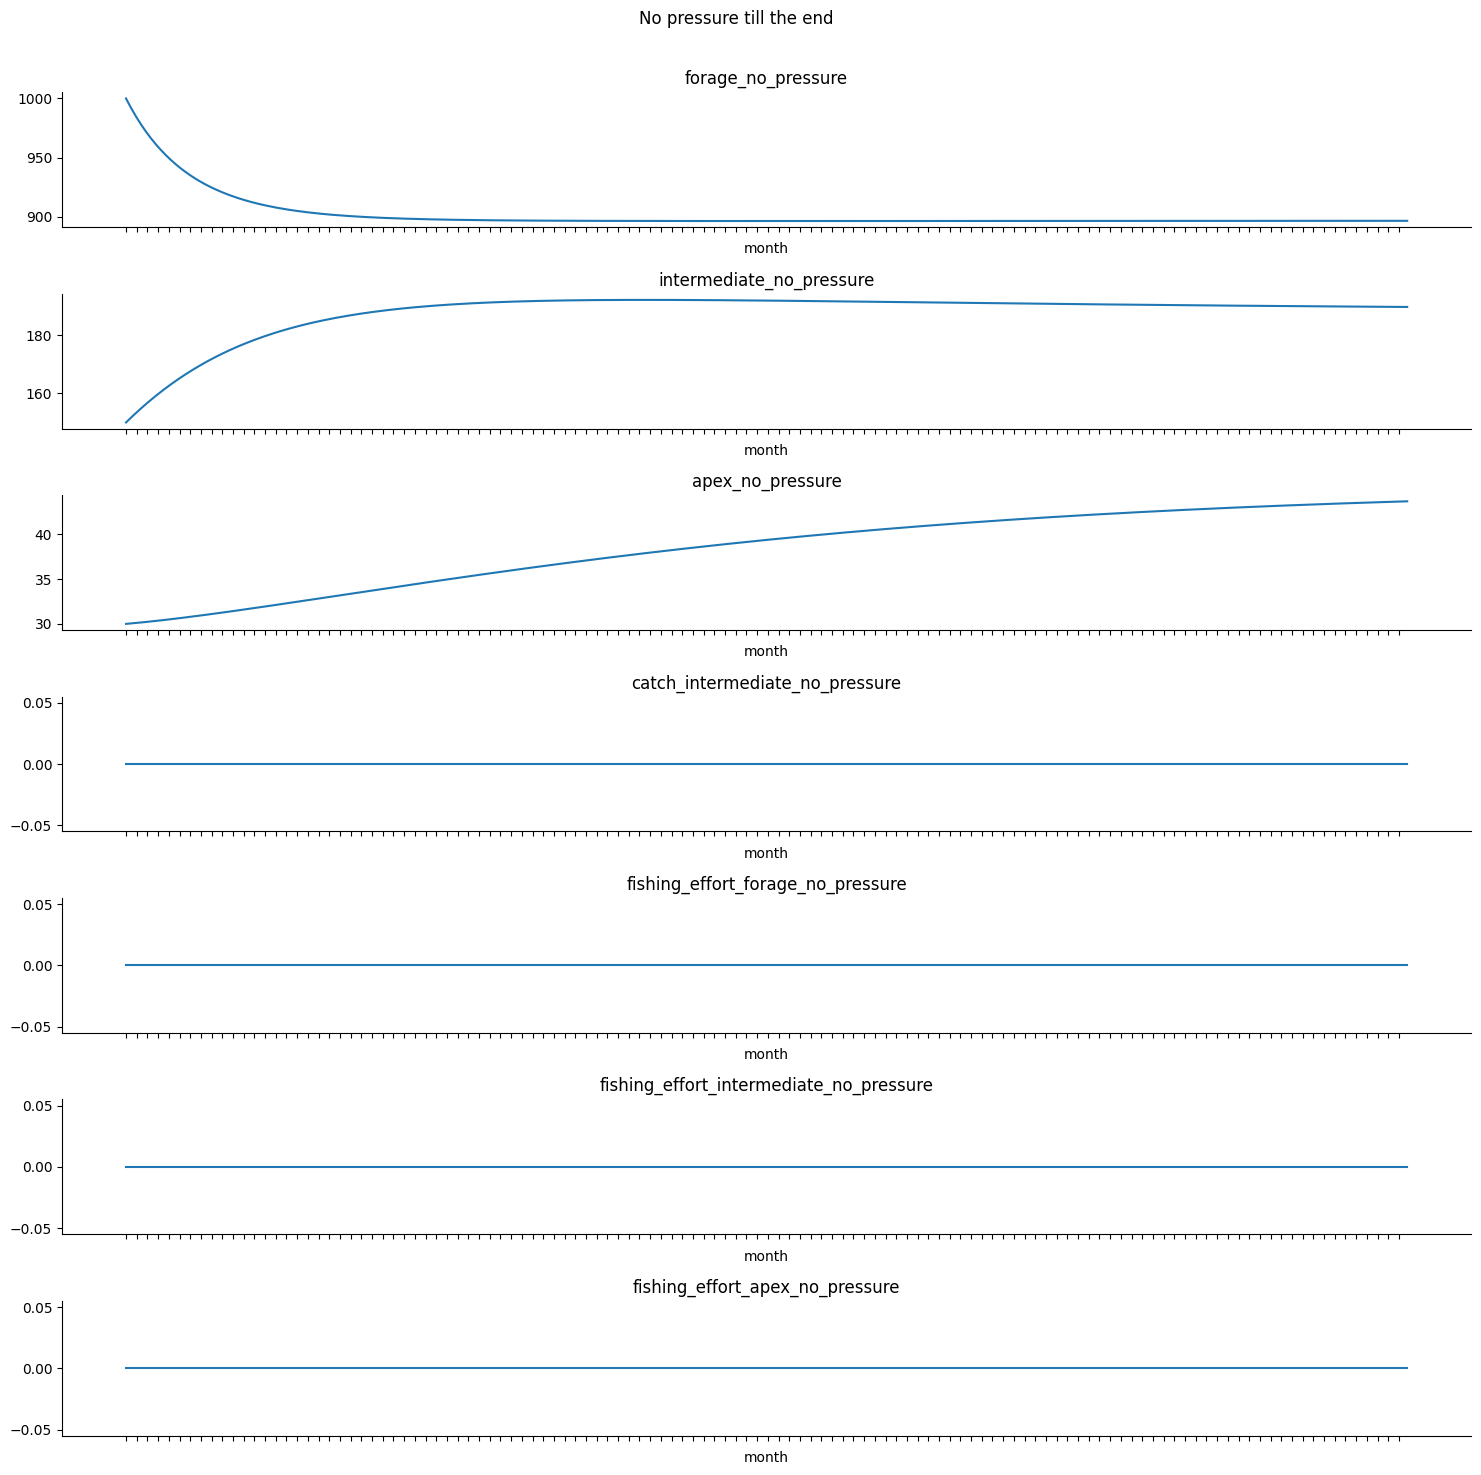

In [6]:
fish_dynamics_pressure = FishDynamics(postfix = "pressure")
fish_dynamics_no_pressure = FishDynamics(postfix = "no_pressure")

start_time = torch.tensor(0.0)
end_time = torch.tensor(1)
end_of_the_world = torch.tensor(10.)
step_size = torch.tensor(1/52)
logging_times = torch.arange(start_time, end_time, step_size)
end_of_the_world_logging_times = torch.arange(start_time, end_of_the_world, step_size)


with TorchDiffEq(), LogTrajectory(end_of_the_world_logging_times) as lt_end:
    simulate(fish_dynamics_no_pressure, INITIAL_STATE_NO_PRESSURE, start_time, end_of_the_world,)

trajectory_end = lt_end.trajectory

plot_trajectories(trajectory_end, "No pressure till the end", end_of_the_world_logging_times)

In [7]:
trajectory_end.keys()

stable_initial_biomass = {
    "forage": trajectory_end['forage_no_pressure'][-1],
    "intermediate": trajectory_end['intermediate_no_pressure'][-1],
    "apex": trajectory_end['apex_no_pressure'][-1],
}

print(stable_initial_biomass)

{'forage': tensor(896.7038), 'intermediate': tensor(189.8233), 'apex': tensor(43.7029)}


In [8]:
def update_init_with_equilibrium(init: Dict):
    for  key_stable in stable_initial_biomass:
        for key in init.keys():
            if key.startswith(key_stable):
                init[key] = stable_initial_biomass[key_stable]

    return init

# update to median-based 10 year near-equilibrium biomass states
INITIAL_STATE_NO_PRESSURE = update_init_with_equilibrium(INITIAL_STATE_NO_PRESSURE)
INITIAL_STATE_PRESSURE = update_init_with_equilibrium(INITIAL_STATE_PRESSURE)
INITIAL_STATE_DEPENDENT = update_init_with_equilibrium(INITIAL_STATE_DEPENDENT)
INITIAL_STATE_STATIC = update_init_with_equilibrium(INITIAL_STATE_STATIC)


In [9]:
with TorchDiffEq(), LogTrajectory(logging_times) as lt_no_pressure:
    simulate(fish_dynamics_no_pressure, INITIAL_STATE_NO_PRESSURE, start_time, end_time,)

trajectory_no_pressure = lt_no_pressure.trajectory

In [10]:
with TorchDiffEq(), LogTrajectory(logging_times) as lt_pressure:
    simulate(fish_dynamics_pressure, INITIAL_STATE_PRESSURE, start_time, end_time)
trajectory_pressure = lt_pressure.trajectory

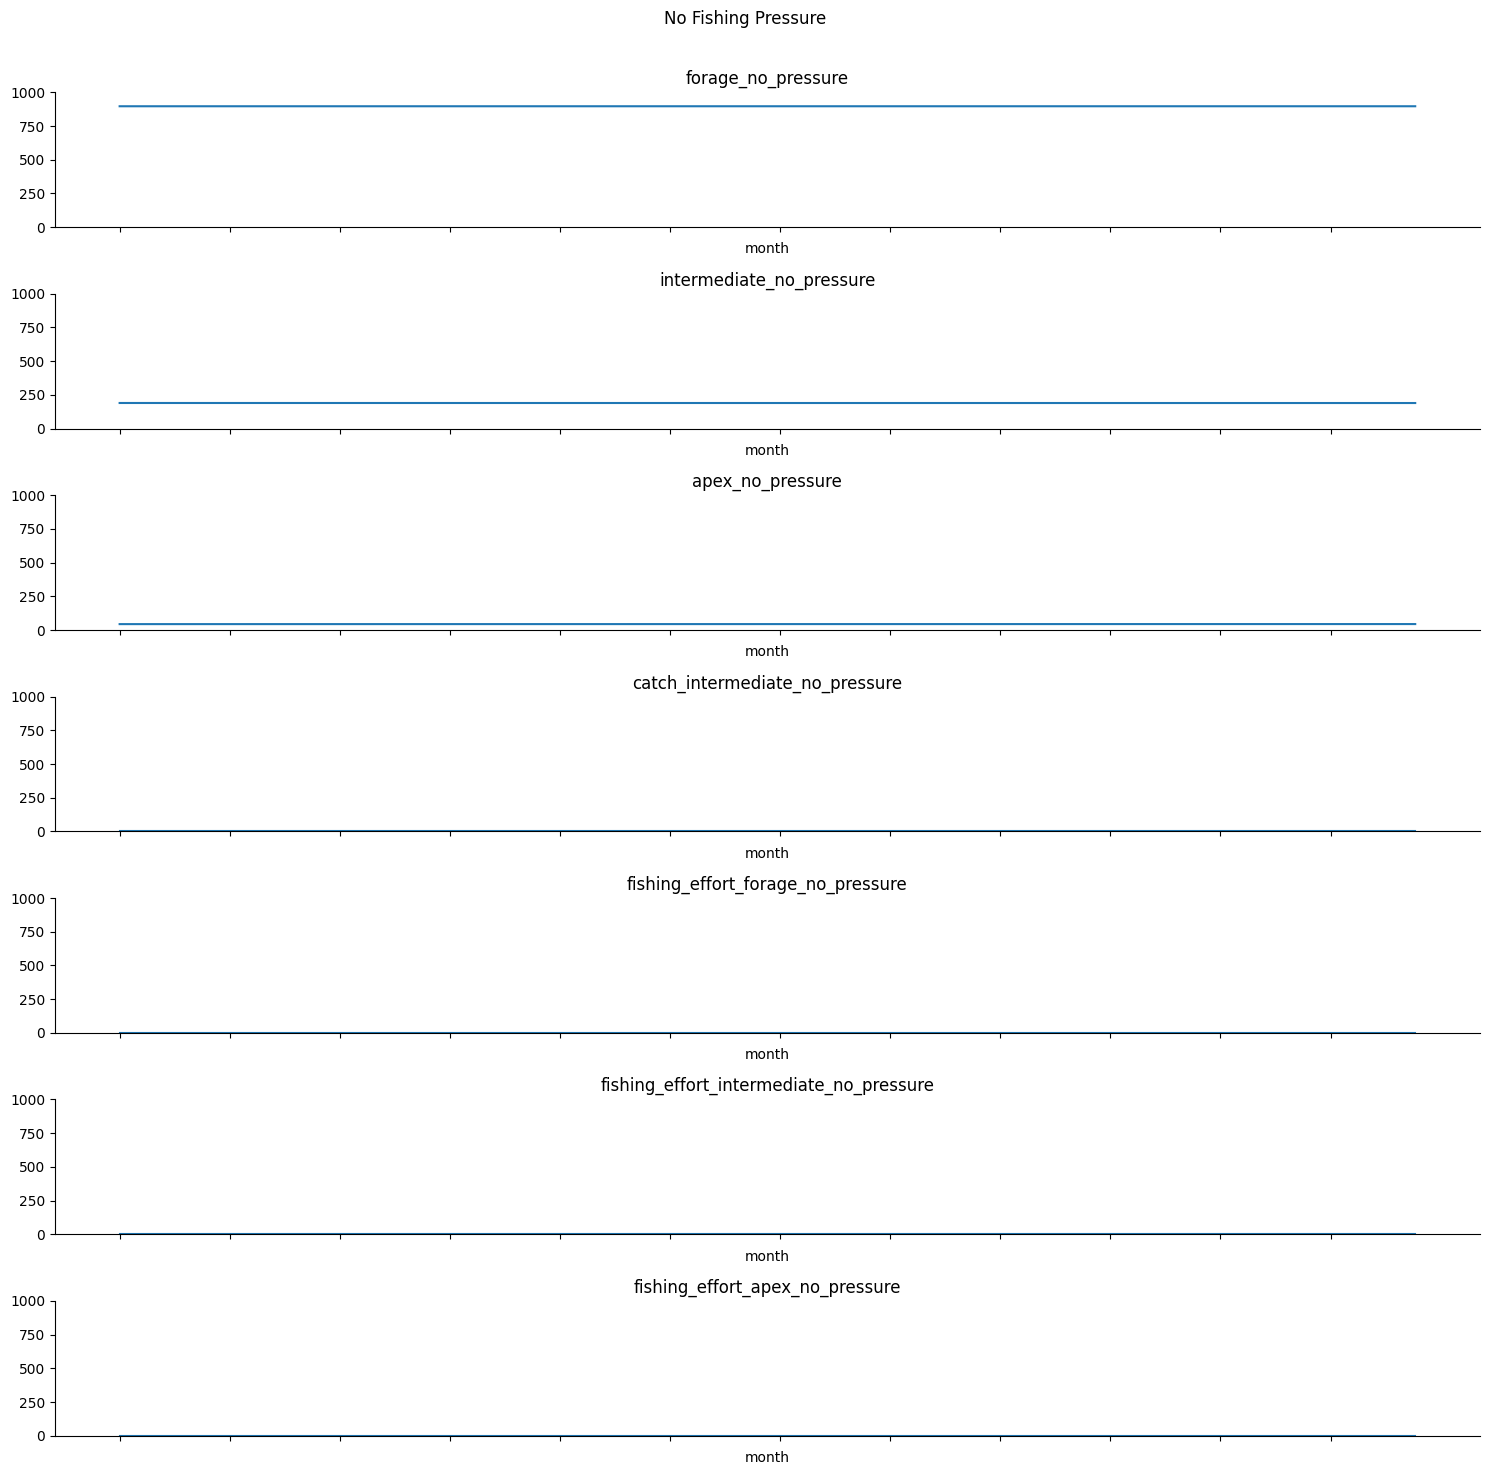

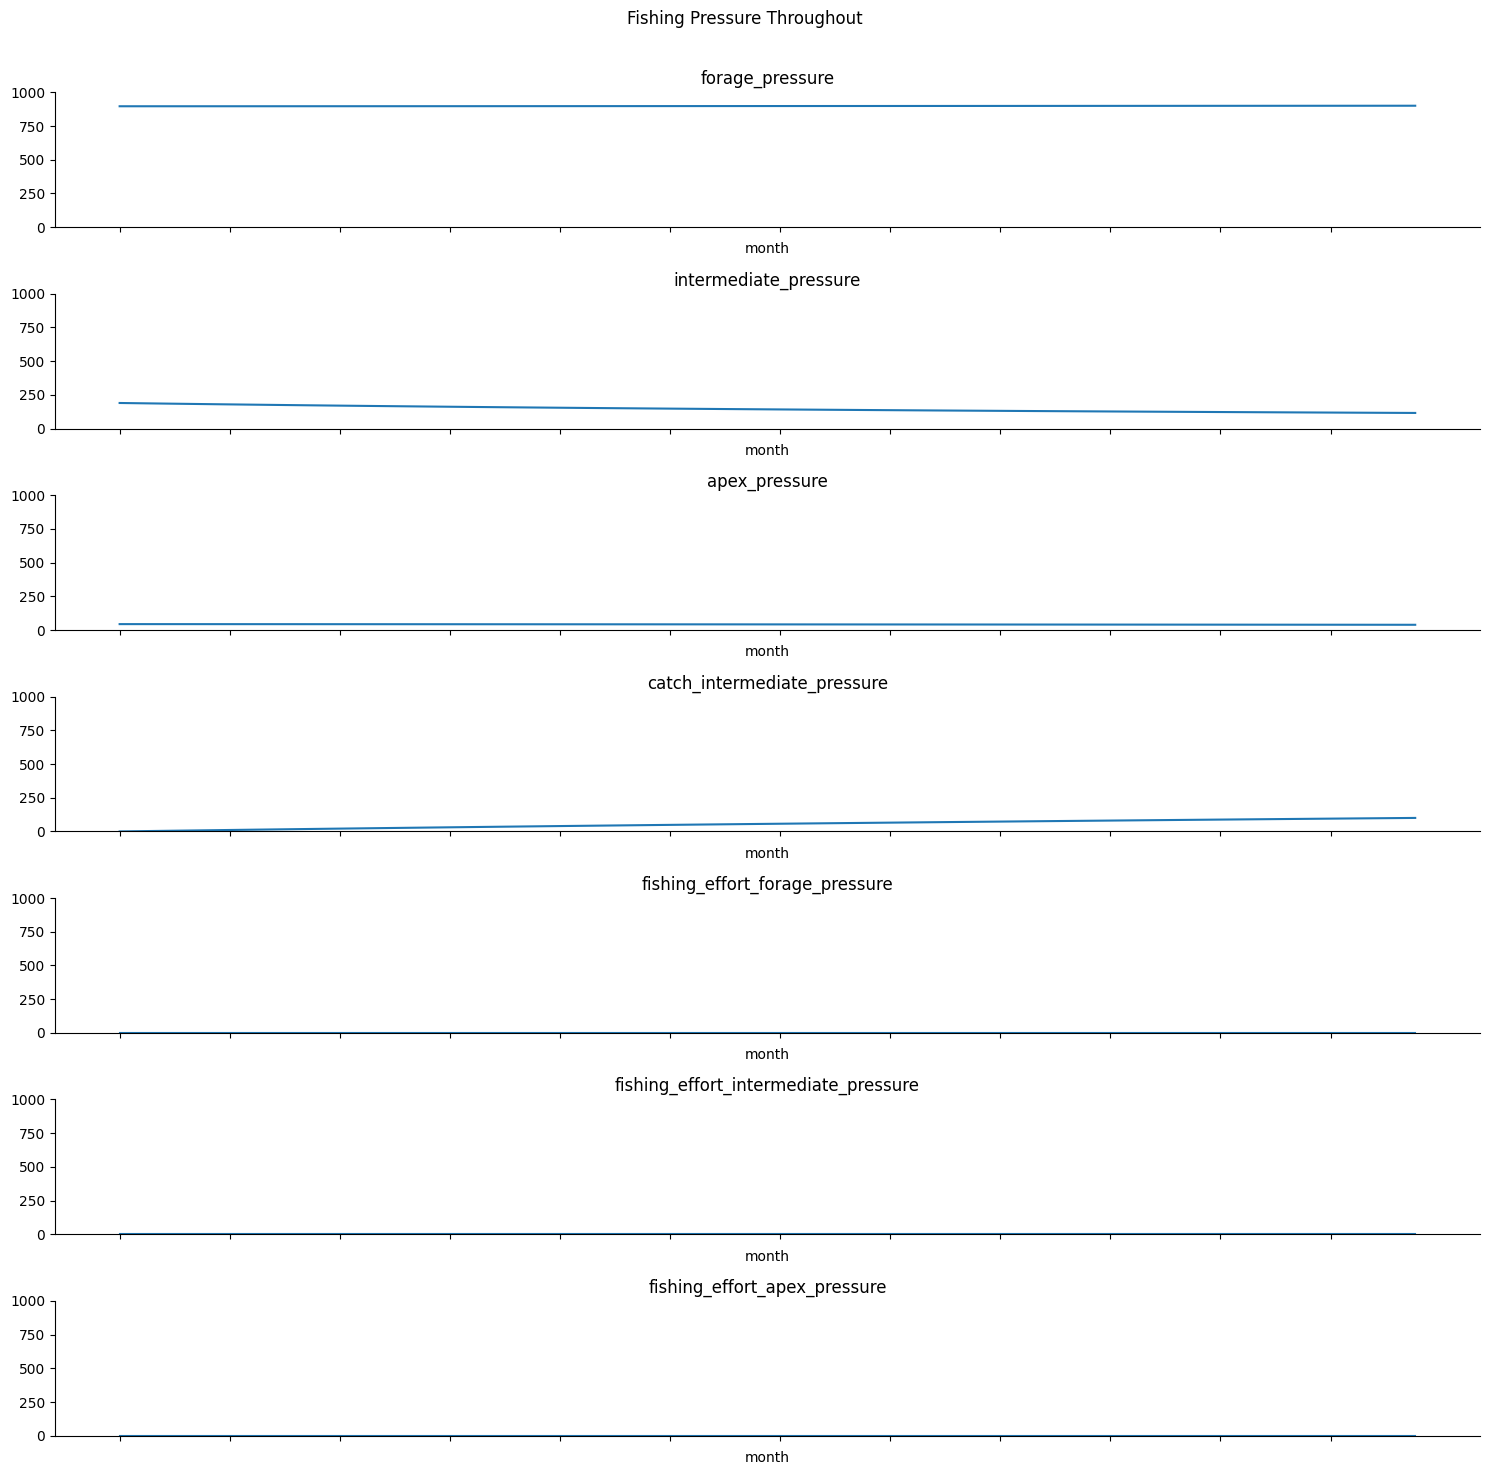

In [11]:
plot_trajectories(trajectory_no_pressure, "No Fishing Pressure", logging_times=logging_times, ylim = (0, 1000))
plot_trajectories(trajectory_pressure, "Fishing Pressure Throughout", logging_times=logging_times, ylim = (0, 1000))

## Incorporate uncertainty about model parameters

In [12]:
def stop_fishing_policy(target_state: State[torch.tensor], postfix: str = "dependent"):
    """
    The event function for the stop fishing policy. This is a function
    that passes zero when the catch of the intermediate fish passes a quota
    specified by `target_state`.
    """
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return  state[f"catch_intermediate_{postfix}"] - target_state[f"catch_intermediate_{postfix}"]
    return event_f

In [13]:
quota = {'catch_intermediate_dependent': torch.tensor(40.)}
season_ends = {key: torch.tensor(0.) for key in INITIAL_STATE_DEPENDENT.keys() if key.startswith('fishing_effort')}
# NOTICE: no warning if the intervention key is not in the state!! (eg. INITIAL_STATE_PRESSURE.keys())



In [14]:
# add uncertainty about initial state

print("before no pressure", INITIAL_STATE_NO_PRESSURE)
def randomize_init_state(init: Dict, postfix = ""):
    init = init.copy()

    if postfix != "":
        postfix = "_"+postfix
    for key, value in init.items():

        if key.startswith('forage'):
            init[key] = pyro.sample(f"forage_init{postfix}", dist.Uniform(init[key]-20, init[key]+20))
        elif key.startswith('intermediate'):
            init[key] = pyro.sample(f"intermediate_init{postfix}", dist.Uniform(init[key]-10, init[key]+10))
        elif key.startswith('apex'):
            init[key] = pyro.sample(f"apex_init{postfix}", dist.Uniform(init[key]-2, init[key]+2))

    return init


randomized_no_pressure = randomize_init_state(INITIAL_STATE_NO_PRESSURE, "")
print("randomized no pressure",
randomized_no_pressure
)
print("initial pressure", INITIAL_STATE_PRESSURE)

def copy_init_state_values(source: Dict, target, postfix: str):
    init = target.copy()
    for key in source.keys():
        if key.startswith("forage"):
            init[f"forage_{postfix}"] = source[key]
        elif key.startswith('intermediate'):
            init[f"intermediate_{postfix}"] =  source[key]
        elif key.startswith('apex'):
            init[f"apex_{postfix}"] = source[key]

    return init


# print(INITIAL_STATE_PRESSURE)

INITIAL_STATE_PRESSURE_copied = copy_init_state_values(source = randomized_no_pressure, target = INITIAL_STATE_PRESSURE, postfix = "pressure")

print(INITIAL_STATE_PRESSURE_copied)

before no pressure {'forage_no_pressure': tensor(896.7038), 'intermediate_no_pressure': tensor(189.8233), 'apex_no_pressure': tensor(43.7029), 'catch_intermediate_no_pressure': tensor(0.), 'fishing_effort_forage_no_pressure': tensor(0.), 'fishing_effort_intermediate_no_pressure': tensor(0), 'fishing_effort_apex_no_pressure': tensor(0.)}
randomized no pressure {'forage_no_pressure': tensor(903.2076), 'intermediate_no_pressure': tensor(192.9426), 'apex_no_pressure': tensor(41.7296), 'catch_intermediate_no_pressure': tensor(0.), 'fishing_effort_forage_no_pressure': tensor(0.), 'fishing_effort_intermediate_no_pressure': tensor(0), 'fishing_effort_apex_no_pressure': tensor(0.)}
initial pressure {'forage_pressure': tensor(896.7038), 'intermediate_pressure': tensor(189.8233), 'apex_pressure': tensor(43.7029), 'catch_intermediate_pressure': tensor(0.), 'fishing_effort_forage_pressure': tensor(0.), 'fishing_effort_intermediate_pressure': tensor(0.7000), 'fishing_effort_apex_pressure': tensor(0.

In [18]:
print(INITIAL_STATE_NO_PRESSURE, "\n",
INITIAL_STATE_PRESSURE, "\n" , 
INITIAL_STATE_DEPENDENT, "\n" ,
INITIAL_STATE_STATIC
)

{'forage_no_pressure': tensor(896.7038), 'intermediate_no_pressure': tensor(189.8233), 'apex_no_pressure': tensor(43.7029), 'catch_intermediate_no_pressure': tensor(0.), 'fishing_effort_forage_no_pressure': tensor(0.), 'fishing_effort_intermediate_no_pressure': tensor(0), 'fishing_effort_apex_no_pressure': tensor(0.)} 
 {'forage_pressure': tensor(896.7038), 'intermediate_pressure': tensor(189.8233), 'apex_pressure': tensor(43.7029), 'catch_intermediate_pressure': tensor(0.), 'fishing_effort_forage_pressure': tensor(0.), 'fishing_effort_intermediate_pressure': tensor(0.7000), 'fishing_effort_apex_pressure': tensor(0.0700)} 
 {'forage_dependent': tensor(896.7038), 'intermediate_dependent': tensor(189.8233), 'apex_dependent': tensor(43.7029), 'catch_intermediate_dependent': tensor(0.), 'fishing_effort_forage_dependent': tensor(0.), 'fishing_effort_intermediate_dependent': tensor(0.7000), 'fishing_effort_apex_dependent': tensor(0.0700)} 
 {'forage_static': tensor(896.7038), 'intermediate_s

In [19]:
from chirho.dynamical.internals._utils import (
    _squeeze_time_dim,
    _unsqueeze_time_dim,
    append,
)

class LogTrajectoryPostfix(LogTrajectory):
    def __init__(self, times: torch.Tensor, is_traced: bool = False, postfix: str = ""):
        super().__init__(times, is_traced)
        self.postfix = postfix

    def _pyro_post_simulate(self, msg: dict) -> None:
        initial_state: State[T] = msg["args"][1]
        start_time = msg["args"][2]

        if start_time == self.times[0]:

            self._trajectory: State[T] = append(
                _unsqueeze_time_dim(initial_state), self._trajectory
            )

        self.trajectory: State[T] = self._trajectory
        self._trajectory: State[T] = type(initial_state)()

        if self.is_traced:
            [pyro.deterministic(f"{name}_{self.postfix}", value) for name, value in self.trajectory.items()]

In [ ]:
torch.manual_seed(42)
pyro.set_rng_seed(42)

quota_list = [float(x) for x in range(0, 131, 10)]#list(range(0, 21, 10))


def bayesian_parallel_dynamics():

    shared_noise = sample_fishery_priors()

    fish_dynamics_no_pressure = FishDynamics(params = shared_noise, postfix = "no_pressure")
    fish_dynamics_pressure = FishDynamics(params = shared_noise, postfix = "pressure")
    fish_dynamics_state_dependent = FishDynamics(params = shared_noise, postfix = "dependent")

    # the initial state biomass noise is also shared
    INITIAL_STATE_NO_PRESSURE_sample = randomize_init_state(INITIAL_STATE_NO_PRESSURE,)
    INITIAL_STATE_PRESSURE_sample =  copy_init_state_values(source = INITIAL_STATE_NO_PRESSURE_sample,
    target = INITIAL_STATE_PRESSURE, postfix = "pressure")

    INITIAL_STATE_DEPENDENT_sample = copy_init_state_values(source = INITIAL_STATE_NO_PRESSURE_sample,
    target = INITIAL_STATE_DEPENDENT, postfix = "dependent")

    INITIAL_STATE_STATIC_sample = copy_init_state_values(source = INITIAL_STATE_NO_PRESSURE_sample,
    target = INITIAL_STATE_STATIC, postfix = "static")


    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True):
        simulate(fish_dynamics_no_pressure, INITIAL_STATE_NO_PRESSURE_sample, start_time, end_time,)

    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True):
        simulate(fish_dynamics_pressure, INITIAL_STATE_PRESSURE_sample, start_time, end_time)

    
    for quota_limit in [torch.tensor(k) for k in quota_list]:

        quota = {'catch_intermediate_dependent': quota_limit}
        with TorchDiffEq(),LogTrajectoryPostfix(logging_times, is_traced=True, postfix = str(quota_limit.item())):
            with DynamicIntervention(event_fn=stop_fishing_policy(quota), intervention= season_ends):
                        simulate(fish_dynamics_state_dependent, INITIAL_STATE_DEPENDENT_sample, start_time, logging_times[-1])
    
fishery_predictive = Predictive(bayesian_parallel_dynamics, num_samples=num_samples,)
fishery_samples =  fishery_predictive()


In [31]:
fishery_samples.keys()

dict_keys(['r1', 'r2', 'r3', 'd1', 'd2', 'm3', 'k1', 'p12', 'p23', 'e12', 'e23', 'forage_init', 'intermediate_init', 'apex_init', 'forage_no_pressure', 'intermediate_no_pressure', 'apex_no_pressure', 'catch_intermediate_no_pressure', 'fishing_effort_forage_no_pressure', 'fishing_effort_intermediate_no_pressure', 'fishing_effort_apex_no_pressure', 'forage_pressure', 'intermediate_pressure', 'apex_pressure', 'catch_intermediate_pressure', 'fishing_effort_forage_pressure', 'fishing_effort_intermediate_pressure', 'fishing_effort_apex_pressure', 'forage_dependent_40.0', 'intermediate_dependent_40.0', 'apex_dependent_40.0', 'catch_intermediate_dependent_40.0', 'fishing_effort_forage_dependent_40.0', 'fishing_effort_intermediate_dependent_40.0', 'fishing_effort_apex_dependent_40.0', 'forage_dependent_50.0', 'intermediate_dependent_50.0', 'apex_dependent_50.0', 'catch_intermediate_dependent_50.0', 'fishing_effort_forage_dependent_50.0', 'fishing_effort_intermediate_dependent_50.0', 'fishing_ef

In [32]:
pressure_samples = {key: value for key, value in fishery_samples.items() if "pressure" in key and "no" not in key}
no_pressure_samples = {key: value for key, value in fishery_samples.items() if "no_pressure" in key}
dependent_supersamples = {key: value for key, value in fishery_samples.items() if "dependent" in key}

dependent_samples = {}
for q in quota_list:
    dependent_samples[q] = {key: value for key, value in dependent_supersamples.items() if str(q) in key}
    dependent_samples[q].update({key: value for key, value in dependent_supersamples.items() if "init_dependent" in key})

print(
dependent_samples.keys()
)

# pressure_samples_medians    = {key: value.median(dim = 0).values for key, value in pressure_samples.items()}
# no_pressure_samples_medians = {key: value.median(dim = 0).values for key, value in no_pressure_samples.items()}
# dependent_samples_medians = {key: value.median(dim = 0).values for key, value in dependent_samples.items()}

dict_keys([40.0, 50.0])


In [33]:
def plot_trajectory_samples(samples, postfix, title, event_time = None, logging_times = logging_times):

    pressure_samples_medians = {key: value.median(dim = 0).values for key, value in samples.items()}
    pressure_samples_lows = {key: value.quantile(0.05, dim = 0) for key, value in samples.items()}
    pressure_samples_highs = {key: value.quantile(0.95, dim = 0) for key, value in samples.items()}
    
    state_keys = [f'forage_{postfix}', f'intermediate_{postfix}', f'apex_{postfix}', f'catch_intermediate_{postfix}']   

    
    fig, ax = plt.subplots(len(state_keys)+1, 1, figsize=(15, 15))
    
    ax = ax.flatten()
    x_ticks = torch.arange(logging_times.min(), logging_times.max(), 1/12)
    

    for i in range(len(state_keys)):
        key = state_keys[i]
        ax[i].plot(logging_times, pressure_samples_medians[key], label=key)
        ax[i].set_title(key)
        ax[i].fill_between(
            logging_times,
            #torch.arange(pressure_samples_medians[key].shape[0]),
            pressure_samples_lows[key],
            pressure_samples_highs[key],
            alpha=0.2,
        )
        ax[i].set_xticks(x_ticks)
        ax[i].set_xticklabels([])
        ax[i].set_xlabel("month")



        if event_time is not None:
            ax[i].axvline(event_time, color='red', linestyle='--')


    pressure = samples[f'fishing_effort_intermediate_{postfix}']

    average_pressure = False
    if pressure.dim() > 1:
        pressure_low = pressure_samples_lows[f'fishing_effort_intermediate_{postfix}']
        pressure_high = pressure_samples_highs[f'fishing_effort_intermediate_{postfix}']        
        average_pressure = True
        pressure = pressure.median(dim=0).values

    ax[len(state_keys)].plot(logging_times, pressure)
    ax[len(state_keys)].set_title(f'Fishing Effort Intermediate_{postfix}')

    if average_pressure:
        ax[len(state_keys)].fill_between(
            logging_times,
            pressure_low,
            pressure_high,
            alpha=0.2,
        )
    ax[len(state_keys)].set_ylim(-0.1,1)
    ax[len(state_keys)].set_xticks(x_ticks)
    ax[len(state_keys)].set_xticklabels([])
    ax[len(state_keys)].set_xlabel("month")
    


    fig.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    fig.suptitle(title)
    fig.show()
    plt.show()


/tmp/ipykernel_57117/2878895420.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


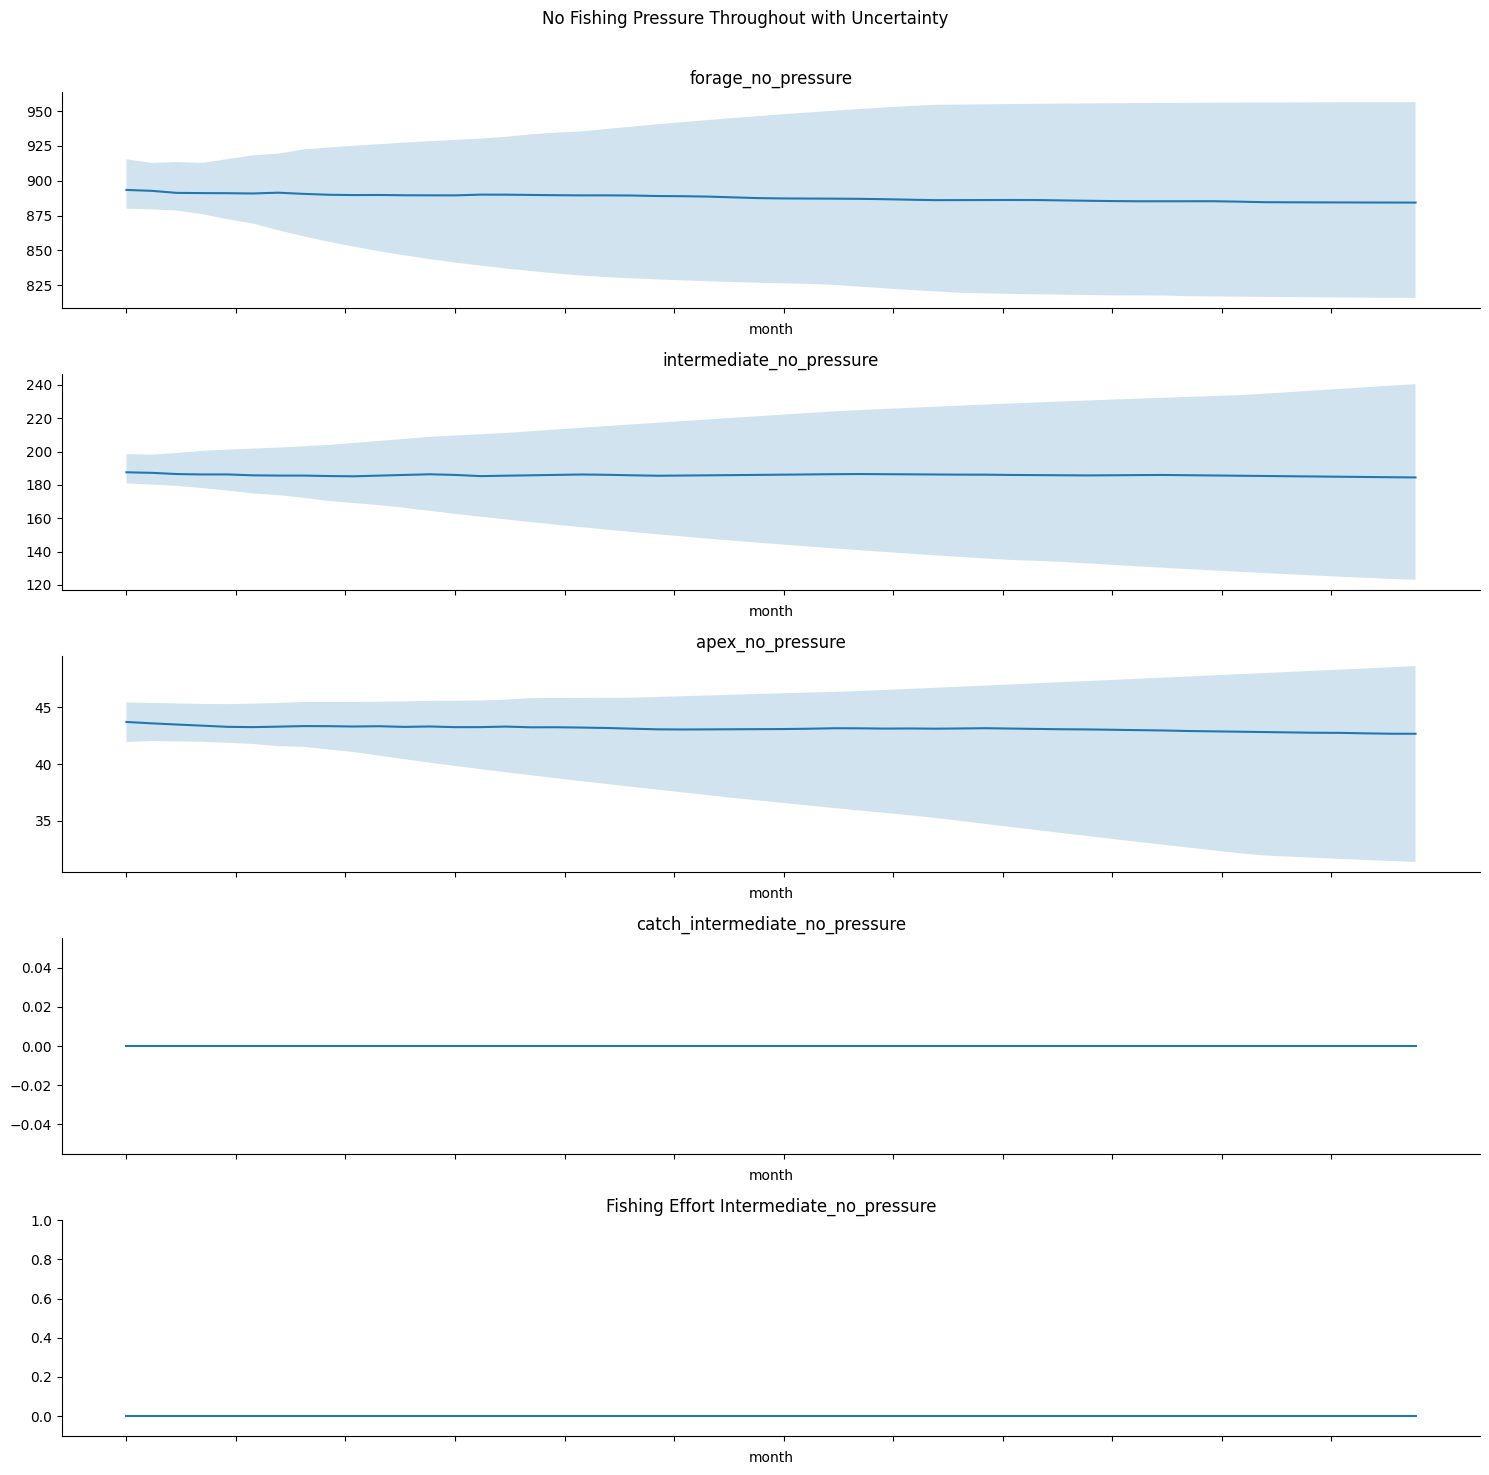

In [34]:
plot_trajectory_samples(no_pressure_samples, postfix = "no_pressure", 
title = "No Fishing Pressure Throughout with Uncertainty")


/tmp/ipykernel_57117/2878895420.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


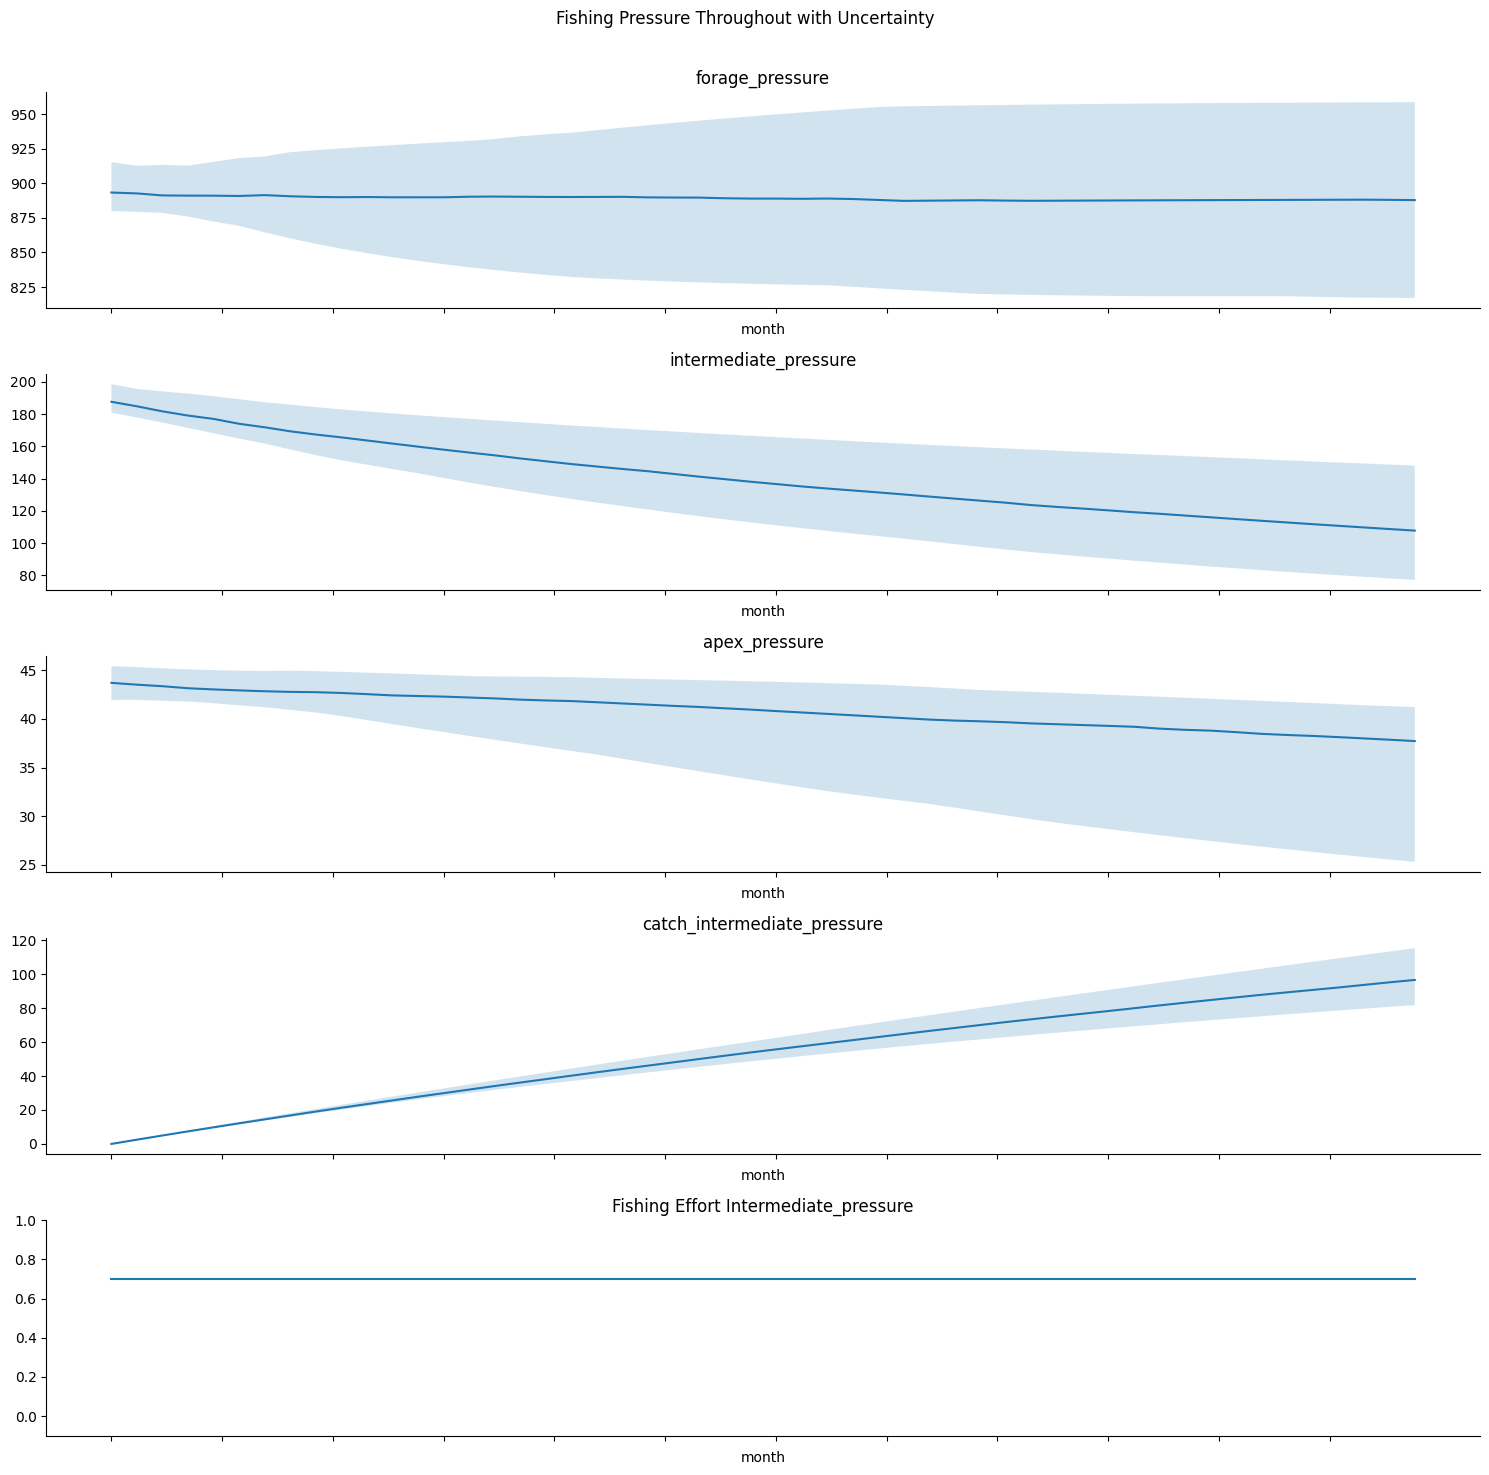

In [35]:
plot_trajectory_samples(pressure_samples, postfix = "pressure", title =  "Fishing Pressure Throughout with Uncertainty")


/tmp/ipykernel_57117/2878895420.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


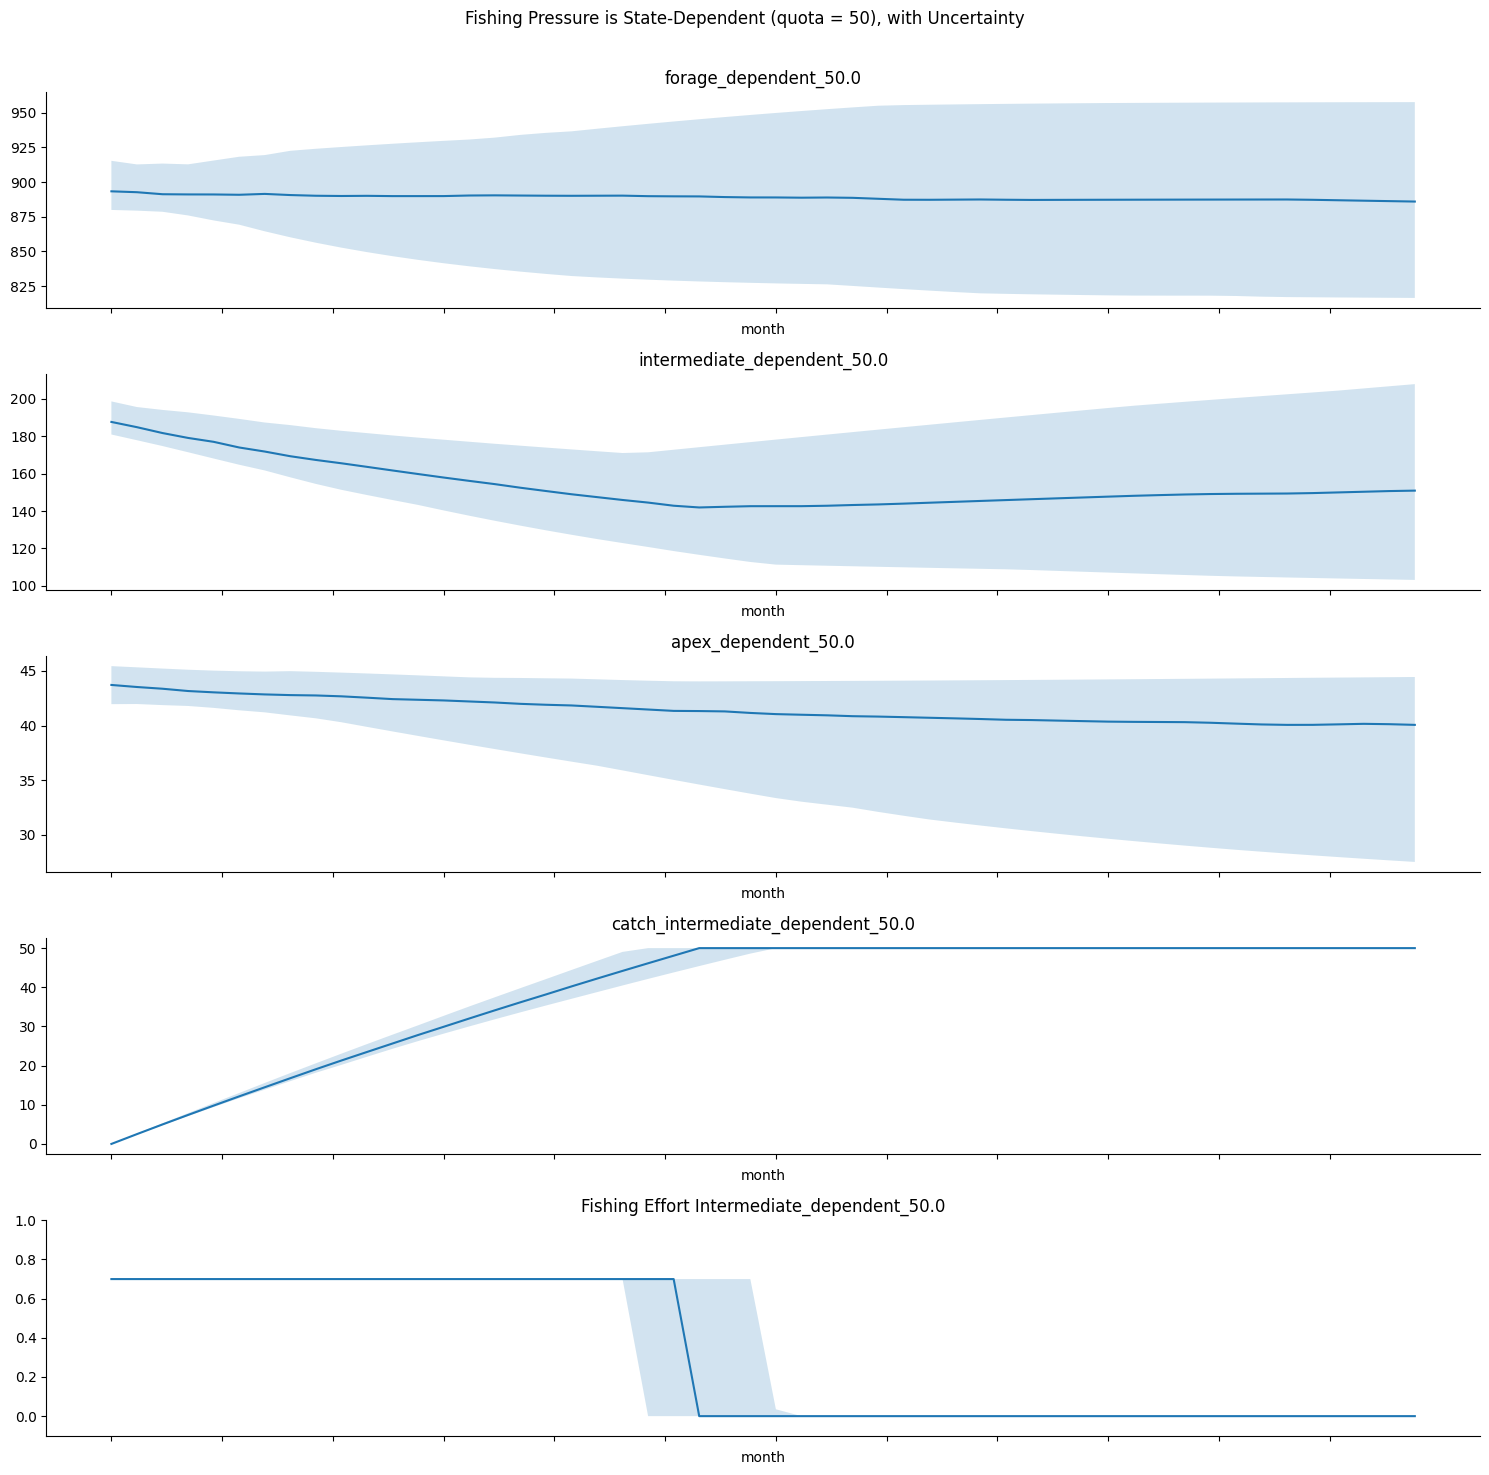

In [39]:
plot_trajectory_samples(dependent_samples[50.0], postfix = "dependent_50.0", 
title =  "Fishing Pressure is State-Dependent (quota = 50), with Uncertainty")


## Compare outcomes

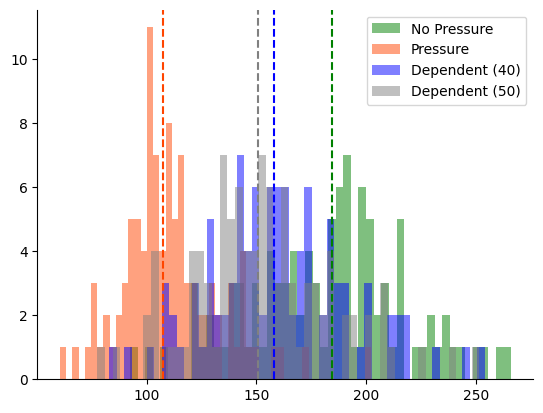

In [44]:



outcome_no_pressure = no_pressure_samples['intermediate_no_pressure'][:,-1]
outcome_pressure = pressure_samples['intermediate_pressure'][:, -1]
outcome_dependent_40 = dependent_samples[40.0][f'intermediate_dependent_{str(40.0)}'][:, -1]
outcome_dependent_50 = dependent_samples[50.0][f'intermediate_dependent_{str(50.0)}'][:, -1]

plt.hist(outcome_no_pressure, bins=50, alpha=0.5, color = "green", label='No Pressure')
plt.axvline(outcome_no_pressure.median(), color='green', linestyle='--')

plt.hist(outcome_pressure, bins=50, alpha=0.5, color = "orangered", label='Pressure')
plt.axvline(outcome_pressure.median(), color='orangered', linestyle='--')

plt.hist(outcome_dependent_40, bins=50, alpha=0.5, color = "blue", label='Dependent (40)')
plt.axvline(outcome_dependent_40.median(), color='blue', linestyle='--')

plt.hist(outcome_dependent_50, bins=50, alpha=0.5, color = "gray", label='Dependent (50)')
plt.axvline(outcome_dependent_50.median(), color='gray', linestyle='--')


plt.legend()

sns.despine()
plt.show()


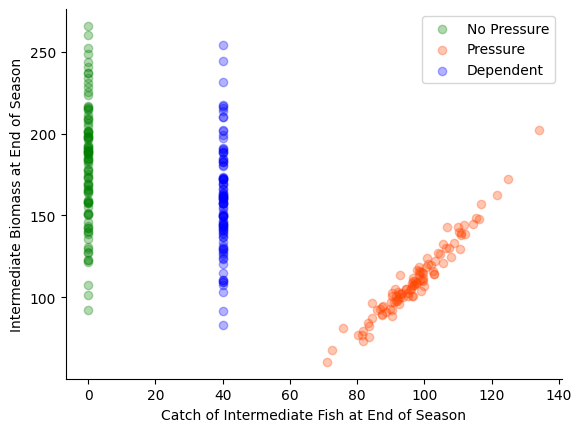

In [ ]:
catch_no_pressure = no_pressure_samples['catch_intermediate_no_pressure'][:,-1]
catch_pressure = pressure_samples['catch_intermediate_pressure'][:, -1]
catch_dependent_40 = dependent_samples[40.0]['catch_intermediate_dependent_40.0'][:, -1]

plt.scatter(catch_no_pressure, outcome_no_pressure, alpha=0.3, color="green", label="No Pressure")
plt.scatter(catch_pressure, outcome_pressure, alpha=0.3, color="orangered", label="Pressure")
plt.scatter(catch_dependent_40, outcome_dependent, alpha=0.3, color="blue", label="Dependent")

plt.legend()
plt.xlabel("Catch of Intermediate Fish at End of Season")
plt.ylabel("Intermediate Biomass at End of Season")
sns.despine()
plt.show()


## Probability of necessity and sufficiency

In [52]:
# What's the probability of the state-dependent policy necessary and sufficient for the intermediate biomass 
# to be above a certain threshold at the end of the season?
# note this involves no conditioning by definition of probability of sufficiency and necessity

threshold = torch.tensor(125.)

((outcome_pressure < threshold).float() *  (outcome_dependent_40 > threshold).float()).mean()



tensor(0.6700)

In [ ]:
def compute_causation_probabilities(dependent_samples, quota, threshold = torch.tensor(130.0)):

    outcome_pressure = pressure_samples['intermediate_pressure'][:, -1]


    outcome_dependent = dependent_samples[quota][f"intermediate_dependent_{str(quota)}"][:, -1]

    mask_dependent = outcome_dependent >= threshold
    mask_pressure = outcome_pressure < threshold
    mask_joint = mask_dependent * mask_pressure


    prob_nec_suff =  mask_joint.float().mean()
    prob_nec = (outcome_pressure[mask_dependent] < threshold).float().mean()
    prob_suff = (outcome_dependent[mask_pressure] >= threshold).float().mean()

    return {"nec": prob_nec, "suff": prob_suff, "nec_suff": prob_nec_suff, 
    "outcome_pressure": outcome_pressure, "outcome_dependent": outcome_dependent,}

causation_dictionary_40 = compute_causation_probabilities(dependent_samples, 40.0)


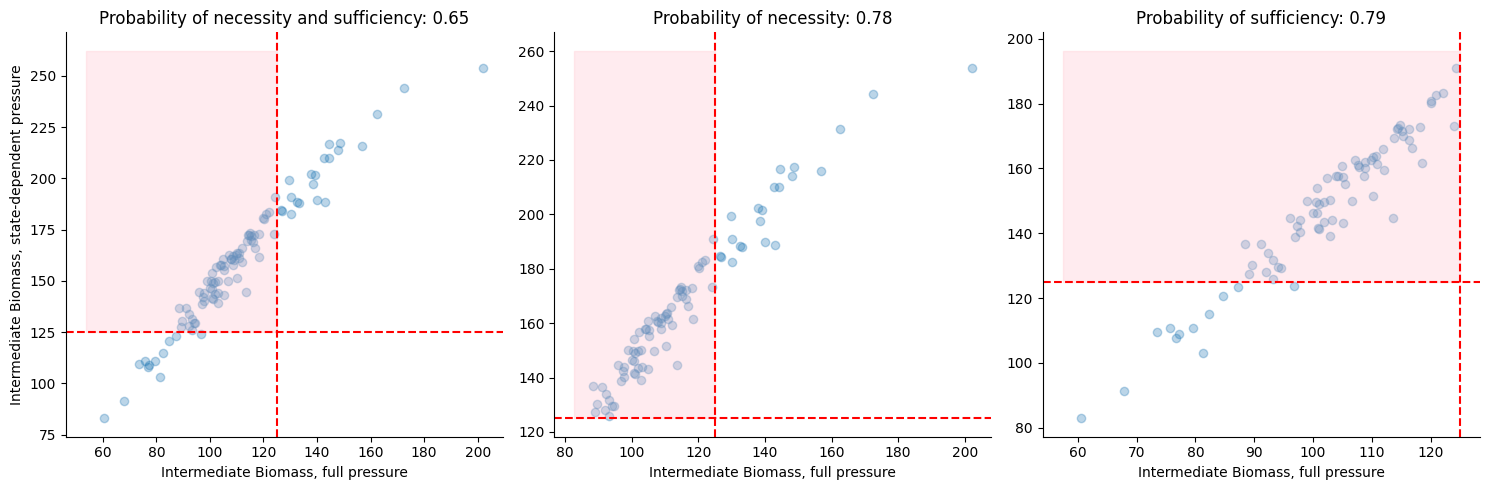

In [69]:
def plot_causation_probs(causation_dictionary):

    prob_nec = causation_dictionary["nec"]
    prob_suff = causation_dictionary["suff"]
    prob_nec_suff = causation_dictionary["nec_suff"]
    outcome_pressure = causation_dictionary["outcome_pressure"]
    outcome_dependent = causation_dictionary["outcome_dependent"]

    mask_dependent = outcome_dependent >= threshold
    mask_pressure = outcome_pressure < threshold
    mask_joint = mask_dependent * mask_pressure

    fig, axes = plt.subplots(1, 3, figsize=(15, 5),)

    axes[0].scatter(outcome_pressure, outcome_dependent, alpha=0.3)
    axes[0].set_xlabel("Intermediate Biomass, full pressure")
    axes[0].set_ylabel("Intermediate Biomass, state-dependent pressure")
    axes[0].axvline(threshold, color='red', linestyle='--')
    axes[0].axhline(threshold, color='red', linestyle='--')
    axes[0].set_title(f"Probability of necessity and sufficiency: {prob_nec_suff:.2f}")
    xlim = axes[0].get_xlim() 
    ylim = axes[0].get_ylim() 
    axes[0].fill_betweenx(y=np.linspace(threshold, ylim[1], 100), x1=xlim[0], x2=threshold, color='pink', alpha=0.3)



    axes[1].scatter(outcome_pressure[mask_dependent], outcome_dependent[mask_dependent], alpha=0.3)
    axes[1].set_xlabel("Intermediate Biomass, full pressure")
    axes[1].axvline(threshold, color='red', linestyle='--')
    axes[1].axhline(threshold, color='red', linestyle='--')
    axes[1].set_title(f"Probability of necessity: {prob_nec:.2f}")
    xlim = axes[1].get_xlim()
    ylim = axes[1].get_ylim()
    axes[1].fill_betweenx(y=np.linspace(threshold, ylim[1], 100), x1=xlim[0], x2=threshold, color='pink', alpha=0.3)


    axes[2].scatter(outcome_pressure[mask_pressure], outcome_dependent[mask_pressure], alpha=0.3)
    axes[2].set_xlabel("Intermediate Biomass, full pressure")
    axes[2].axvline(threshold, color='red', linestyle='--')
    axes[2].axhline(threshold, color='red', linestyle='--')
    axes[2].set_title(f"Probability of sufficiency: {prob_suff:.2f}")

    xlim = axes[2].get_xlim()
    ylim = axes[2].get_ylim()
    axes[2].fill_betweenx(y=np.linspace(threshold, ylim[1], 100), x1=xlim[0], x2=threshold, color='pink', alpha=0.3)

    sns.despine()
    plt.tight_layout()
    plt.show()



plot_causation_probs(causation_dictionary_40)


In [72]:
quota_list
probabilities_of_necessity = []
probabilities_of_sufficiency = []
probabilities_of_necessity_and_sufficiency = []

for quota in quota_list:
    causation_dictionary = compute_causation_probabilities(dependent_samples, quota)

    probabilities_of_necessity.append(causation_dictionary['nec'])
    probabilities_of_sufficiency.append(causation_dictionary['suff'])
    probabilities_of_necessity_and_sufficiency.append(causation_dictionary['nec_suff'])

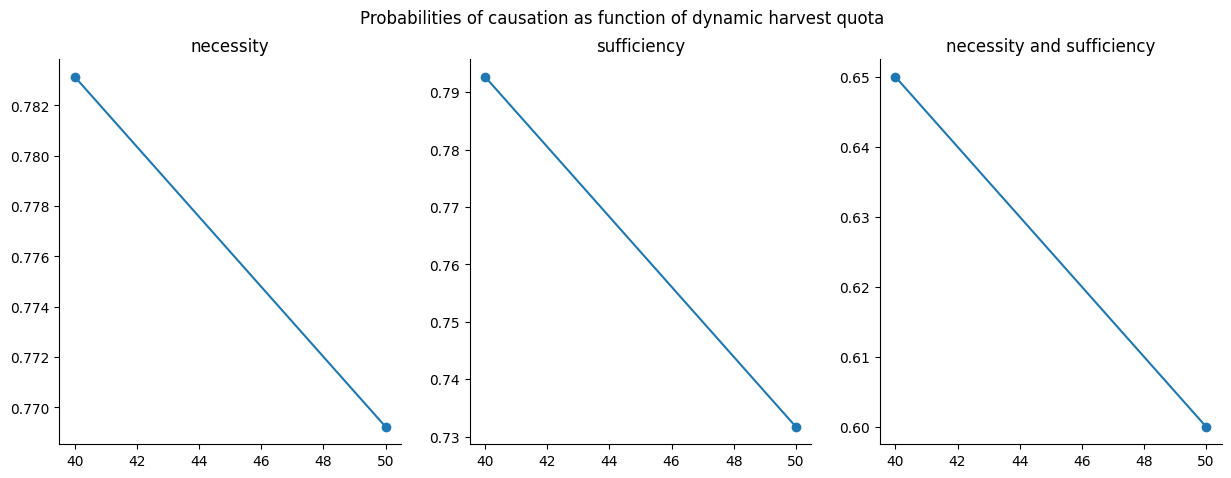

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax = ax.flatten()

ax[0].plot(quota_list, probabilities_of_necessity)
ax[0].scatter(quota_list, probabilities_of_necessity)
ax[0].set_title("necessity")

ax[1].plot(quota_list, probabilities_of_sufficiency)
ax[1].scatter(quota_list, probabilities_of_sufficiency)
ax[1].set_title("sufficiency")

ax[2].plot(quota_list, probabilities_of_necessity_and_sufficiency)
ax[2].scatter(quota_list, probabilities_of_necessity_and_sufficiency)
ax[2].set_title("necessity and sufficiency")




sns.despine()

plt.suptitle("Probabilities of causation as function of dynamic harvest quota")
plt.show()

## Time of event intervention

In [23]:
class LogTrajectoryAndInterventionTime(LogTrajectory):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.recorded_interruption_time = False
    def _pyro_post_simulate_to_interruption(self, msg):
        if not self.recorded_interruption_time:
            self.recorded_interruption_time = True
            self.interruption_time = msg['value'][1]
            self.interruption_state = msg['value'][0]
            if self.is_traced:       
                pyro.deterministic("interruption_time", msg['value'][1])
                for key in self.interruption_state.keys():
                    pyro.deterministic(f"interruption_state_{key}", msg['value'][0][key])
                

In [24]:
intervention_grid_size = 30

def TOE_dynamics(num_samples, intervention_grid_size, threshold = threshold, quota = quota, minimal_cutoff_point = torch.tensor(0.3)):
    
    def internal_dynamics():

        shared_noise = sample_fishery_priors()
 
        fish_dynamics_state_dependent = FishDynamics(params = shared_noise, postfix = "dependent")

        with TorchDiffEq(),LogTrajectoryAndInterventionTime(logging_times, is_traced=True) as lt_dependent:
            with DynamicIntervention(event_fn=stop_fishing_policy(quota), intervention= season_ends):
                simulate(fish_dynamics_state_dependent, INITIAL_STATE_DEPENDENT, start_time, logging_times[-1])

    
    dynamical_predictive = Predictive(internal_dynamics, num_samples=num_samples,)
    dynamical_samples =  dynamical_predictive()

    param_keys = [ key for key in sample_fishery_priors().keys()]
    grabbed_noise = {key: dynamical_samples[key] for key in param_keys}

    season_ends_static = {key.replace("_dependent", "_static"): season_ends[key] for key in season_ends.keys()}


    # conditioning mask
    outcome_above_threshold_mask = dynamical_samples['intermediate_dependent'][:,-1] > threshold

    intervention_times = (torch.linspace(minimal_cutoff_point, 1, intervention_grid_size))
    intervened_outcomes = torch.zeros((num_samples, intervention_grid_size -1))
    intervened_intermediates = []
    intervened_catches = [] #bad English, think of a better plural:)

    print(intervention_times)

    for intervention_index in range(intervention_grid_size -1):
        intervention_time = intervention_times[intervention_index]

        
        intervention_applied_mask = dynamical_samples['interruption_time'] < intervention_time
    
        joint_mask = outcome_above_threshold_mask * intervention_applied_mask

        def static_runs():
            shared_noise = sample_fishery_priors() #will be overriden
            fish_dynamics_static = FishDynamics(params = shared_noise, postfix = "static")

            with MultiWorldCounterfactual() as mwc:
                with StaticIntervention(time = intervention_time, 
                        intervention = season_ends_static):
                    with TorchDiffEq(),LogTrajectory(logging_times, is_traced=True) as lt_static:
                        simulate(fish_dynamics_static, INITIAL_STATE_STATIC, start_time, logging_times[-1])

            catch = lt_static.trajectory['catch_intermediate_static'].squeeze()
            intermediate = lt_static.trajectory['intermediate_static'].squeeze()

            intervened_catch = pyro.deterministic("intervened_catch", catch[1,1,1,:])
            intervened_intermediate = pyro.deterministic("intervened_intermediate", intermediate[1,1,1,:])
            intervened_outcome = pyro.deterministic("intervened_outcome", intervened_intermediate[...,-1])

        # This still fails
        # with mwc:
        #     intervened_catch =  gather(catch, IndexSet(**{key: {1} for key in season_ends_static.keys()})) 
        #     intervened_intermediate = gather(intermediate, IndexSet(**{key: {1} for key in season_ends_static.keys()})) 

               
        predictive_static = Predictive(static_runs, num_samples=1,)
    
        with do(actions = grabbed_noise):
            static_samples = predictive_static()

        assert torch.allclose(static_samples['r1'], grabbed_noise['r1'])
        
        intervened_outcomes[:, intervention_index] = static_samples['intervened_outcome']
        intervened_intermediates.append(static_samples['intervened_intermediate'])
        intervened_catches.append(static_samples['intervened_catch'])
    
    intervention_times = intervention_times[...,:-1]

    return intervened_intermediates, intervened_catches,  intervened_outcomes, intervention_times


intervened_intermediates, intervened_catches, intervened_outcomes, intervention_times = TOE_dynamics(num_samples=50, intervention_grid_size=intervention_grid_size)

tensor([0.3000, 0.3241, 0.3483, 0.3724, 0.3966, 0.4207, 0.4448, 0.4690, 0.4931,
        0.5172, 0.5414, 0.5655, 0.5897, 0.6138, 0.6379, 0.6621, 0.6862, 0.7103,
        0.7345, 0.7586, 0.7828, 0.8069, 0.8310, 0.8552, 0.8793, 0.9034, 0.9276,
        0.9517, 0.9759, 1.0000])


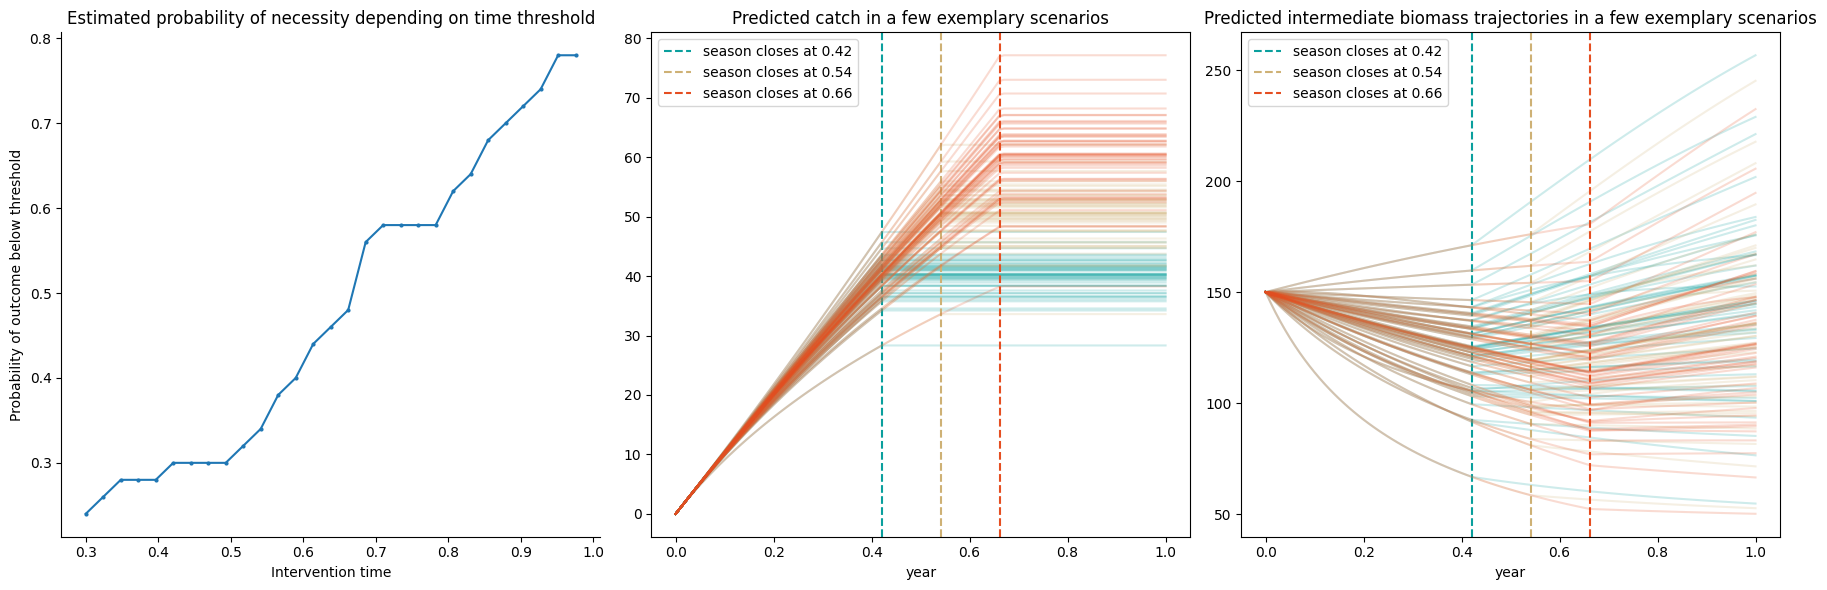

In [25]:
timewise_probabilities = (intervened_outcomes < threshold).float().mean(dim = 0)

assert timewise_probabilities.shape == intervention_times.shape

cmap = load_cmap("AsteroidCity1")
c_index = 0

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for proper spacing

axes[0].plot(intervention_times, timewise_probabilities)
axes[0].scatter(intervention_times, timewise_probabilities, s=4)
axes[0].set_xlabel("Intervention time")
axes[0].set_ylabel("Probability of outcome below threshold")
axes[0].set_title("Estimated probability of necessity depending on time threshold")
sns.despine(ax=axes[0])

c_index = 0
for index in [5, 10, 15]:
    color = cmap(c_index)
    c_index += 1
    catch_samples = intervened_catches[index].squeeze()
    for i in range(catch_samples.shape[0]):
        axes[1].plot(logging_times, catch_samples[i, :], alpha=0.2, color=color)  # Consistent color mapping

    axes[1].set_xlabel("year")
    axes[1].set_title("Predicted catch in a few exemplary scenarios")
    axes[1].axvline(x=intervention_times[index], color=color, linestyle='--', label=f"season closes at {intervention_times[index]:.2f}")
    axes[1].legend()

c_index = 0
for index in [5, 10, 15]:
    color = cmap(c_index)
    c_index += 1
    intermediate_samples = intervened_intermediates[index].squeeze()
    for i in range(intermediate_samples.shape[0]):
        axes[2].plot(logging_times, intermediate_samples[i, :], alpha=0.2, color=color)  # Consistent color mapping

    axes[2].set_xlabel("year")
    axes[2].set_title("Predicted intermediate biomass trajectories in a few exemplary scenarios")
    axes[2].axvline(x=intervention_times[index], color=color, linestyle='--', label=f"season closes at {intervention_times[index]:.2f}")
    axes[2].legend()


plt.tight_layout()
plt.show()


## Outdated TOE

In [86]:
def TOE_dynamics(num_samples, intervention_grid_size, threshold = threshold, quota = quota, tau = torch.tensor(0.28)):
    
    def internal_dynamics():

        shared_noise = sample_fishery_priors()
 
        fish_dynamics_state_dependent = FishDynamics(params = shared_noise, postfix = "dependent")

        with TorchDiffEq(),LogTrajectoryAndInterventionTime(logging_times, is_traced=True) as lt_dependent:
            with DynamicIntervention(event_fn=stop_fishing_policy(quota), intervention= season_ends):
                simulate(fish_dynamics_state_dependent, INITIAL_STATE_DEPENDENT, start_time, logging_times[-1])

    
    dynamical_predictive = Predictive(internal_dynamics, num_samples=num_samples,)
    dynamical_samples =  dynamical_predictive()

    # conditioning mask
    outcome_above_threshold_mask = dynamical_samples['intermediate_dependent'][:,-1] > threshold
    intervention_applied_mask = dynamical_samples['interruption_time'] < tau
    joint_mask = outcome_above_threshold_mask * intervention_applied_mask

    end_times = logging_times[-1]  - dynamical_samples['interruption_time']

    intervention_times = (torch.linspace(0, 1, intervention_grid_size) * end_times.max())[1:-1]

    static_logging_times = torch.cat([end_times, intervention_times])

    #sort static logging times
    static_logging_times, indices = torch.sort(static_logging_times)
    end_time_indices  = torch.nonzero(
        static_logging_times == end_times.unsqueeze(1),
         as_tuple=True)[1]


    param_keys = [ key for key in sample_fishery_priors().keys()]
    grabbed_noise = {key: dynamical_samples[key] for key in param_keys}

    init_state_keys_old = INITIAL_STATE_DEPENDENT.keys()

    init_states = {key.replace("_dependent", "_static"): dynamical_samples[f"interruption_state_{key}"] for key in init_state_keys_old}
    season_ends_static = {key.replace("_dependent", "_static"): season_ends[key] for key in season_ends.keys()}

    
    intervened_outcomes = []

    for intervention_time in intervention_times:

        assert intervention_time in static_logging_times
    
        def static_runs():
            shared_noise = sample_fishery_priors() #will be overriden
            fish_dynamics_static = FishDynamics(params = shared_noise, postfix = "static")

#TODO add apex to intervention
            with MultiWorldCounterfactual():
                with StaticIntervention(time = intervention_time, 
                            intervention = {'fishing_effort_intermediate_static': torch.Tensor([0.])}):
                    with TorchDiffEq(),LogTrajectory(static_logging_times, is_traced=True) as lt_shifted:
                        simulate(fish_dynamics_static, init_states, start_time, static_logging_times[-1])

#TODO gather and register here

        predictive_static = Predictive(static_runs, num_samples=1,)
    
        with do(actions = grabbed_noise):
            static_samples = predictive_static()

        assert torch.allclose(static_samples['r1'], grabbed_noise['r1'])
    
        intervened_fishing_effort = static_samples['fishing_effort_intermediate_static'][:,1, :, :, :, :]
        intervened_outcome = static_samples['intermediate_static'][:,1, :, :, :, :].squeeze()
        intervened_outcome = torch.gather(intervened_outcome, 1, end_time_indices.unsqueeze(1))
        
        intervened_outcomes.append(intervened_outcome)

    intervened_outcomes_tensor = torch.concat(intervened_outcomes, dim = -1)

    #reject based on the conditioning
    intervened_outcomes_tensor = intervened_outcomes_tensor[joint_mask,:]
    
    

    return intervened_outcomes_tensor, intervention_times



intervened_outcomes, intervention_times = TOE_dynamics(num_samples=4, intervention_grid_size=7)

torch.Size([5])
X torch.Size([15]) tensor([0.0438, 0.0876, 0.1314, 0.1752, 0.2190, 0.0438, 0.0876, 0.1314, 0.1752,
        0.2190, 0.0438, 0.0876, 0.1314, 0.1752, 0.2190])
Y torch.Size([15]) tensor([138.2611, 134.3298, 130.4524, 126.6328, 122.8750, 147.2255, 143.5731,
        139.8417, 136.0405, 132.1793, 147.8221, 143.7822, 139.7560, 135.7524,
        131.7767])


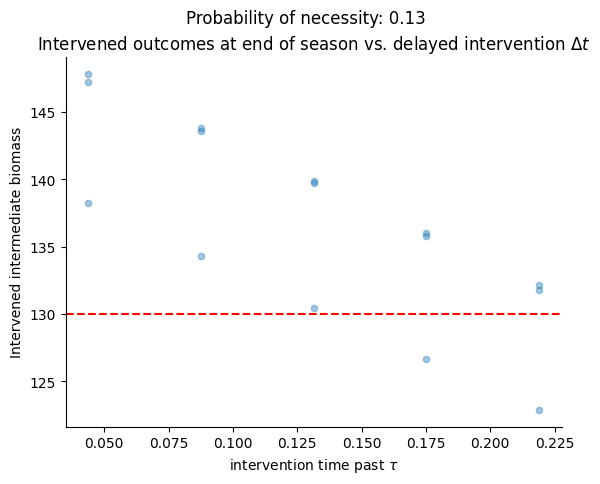

In [87]:
pr_nec = (intervened_outcomes < threshold).float().mean()

print(intervention_times.shape)
x_values = intervention_times.repeat(intervened_outcomes.shape[0]) 
print("X", x_values.shape , x_values)
y_values = intervened_outcomes.flatten()
print("Y", y_values.shape, y_values)
plt.scatter(x_values, y_values, alpha=0.4, s = 20)
plt.axhline(threshold, color='red', linestyle='--')
plt.xlabel("intervention time past $\\tau$")
plt.ylabel("Intervened intermediate biomass")
plt.title("Intervened outcomes at end of season vs. delayed intervention $\\Delta t$")
plt.suptitle(f"Probability of necessity: {pr_nec:.2f}")
sns.despine()
plt.show()

Two plausible questions:

Was the quota being q1 rather than q2 with q1 < q2, necessary and sufficient for the total biomass being above a certain threshold by the start of the next period of interest

## Implementations that don't work`

In [ ]:
with condition(data = param_noise):
    pressure_samples = pressure_predictive(INITIAL_STATE_PRESSURE, start_time, logging_times)


In [ ]:
def dynamic_multiworld_fishing(quota, init_state, start_time, logging_times) -> State:
    dynamics = bayesian_fish_dynamics()
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with MultiWorldCounterfactual():
                with DynamicIntervention(event_fn=stop_fishing_policy(quota), intervention= season_ends):
                    simulate(dynamics, INITIAL_STATE_PRESSURE, start_time, logging_times[-1])
    return lt.trajectory

dynamic_multiworld_predictive = Predictive(dynamic_multiworld_fishing, num_samples=num_samples)
dynamic_multiworld_samples = dynamic_multiworld_predictive(quota,  season_ends, start_time, logging_times)
